# Feature Extraction: Version 4

In [1]:
import glob
import os
import random
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA

In [2]:
TRAIN_DIR = "../data/train"
CLASSES = ["Class A", "Class B", "Class C", "Class D"]

In [3]:
def extract_random_images(directory, class_name, num_images=3):
    class_path = os.path.join(directory, class_name)
    image_files = os.listdir(class_path)
    random_images = random.sample(image_files, num_images)
    images = []
    for img_file in random_images:
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        images.append(img)
    return images

In [4]:
num_images_per_class = 3
all_class_images = {}
for class_name in CLASSES:
    images = extract_random_images(TRAIN_DIR, class_name, num_images_per_class)
    all_class_images[class_name] = images

In [5]:
def load_image(img_path):
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img = np.array(img)
    return img

In [6]:
def apply_pca_to_image(image, pca_model):
    flattened_image = image.reshape(-1)
    pca_components = pca_model.transform([flattened_image])
    reconstructed_image = pca_model.inverse_transform(pca_components)
    reconstructed_image = reconstructed_image.reshape(
        image.shape[0], image.shape[1], -1
    )
    reconstructed_image = reconstructed_image.astype("float32") / 255.0
    return reconstructed_image

## PCA - Basic

In [7]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for class_folder in CLASSES:
        start_time = time.time()
        class_path = os.path.join(folder, class_folder)
        image_files = glob.glob(os.path.join(class_path, "*.png"))
        for img_file in image_files:
            processed_image = load_image(img_file)
            flattened_image = processed_image.flatten()
            images.append(flattened_image)
            labels.append(class_folder)
        end_time = time.time()
        duration = end_time - start_time
        print(f"Processing {class_folder} took {duration} seconds")
    return np.array(images), np.array(labels)

In [8]:
train_images, train_labels = load_images_from_folder(TRAIN_DIR)

Processing Class A took 2.1362109184265137 seconds
Processing Class B took 1.2160890102386475 seconds
Processing Class C took 0.8300678730010986 seconds
Processing Class D took 1.0014829635620117 seconds


In [12]:
pca = PCA(n_components=2500)

In [13]:
pca.fit(X=train_images, y=train_labels)

PCA(n_components=2500)

In [16]:
num_images_per_class = 3
all_class_images = {}
for class_name in CLASSES:
    images = extract_random_images(TRAIN_DIR, class_name, num_images_per_class)
    all_class_images[class_name] = images

--- Class: Class A ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


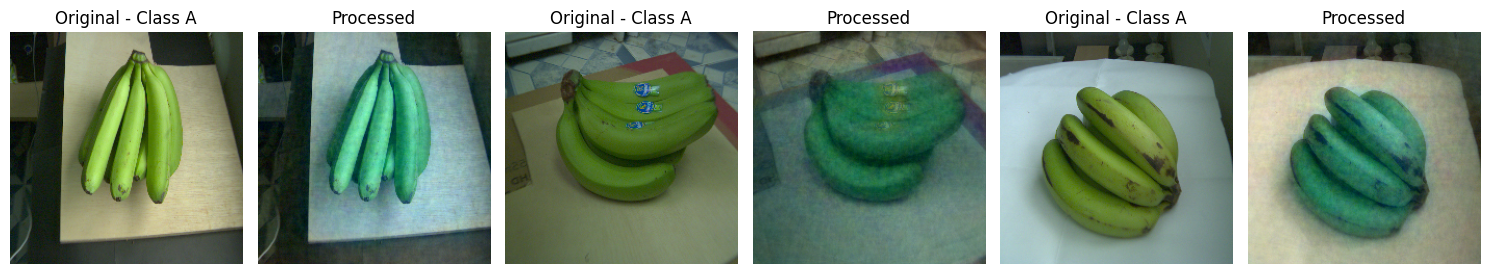

--- Class: Class B ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


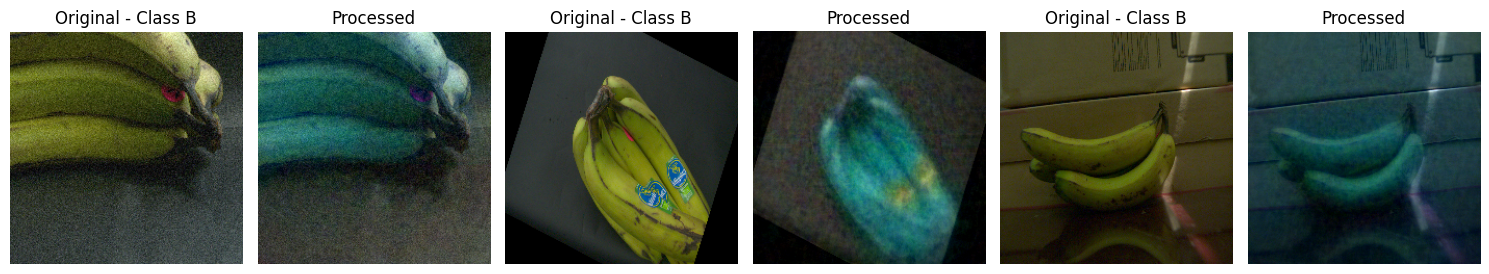

--- Class: Class C ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


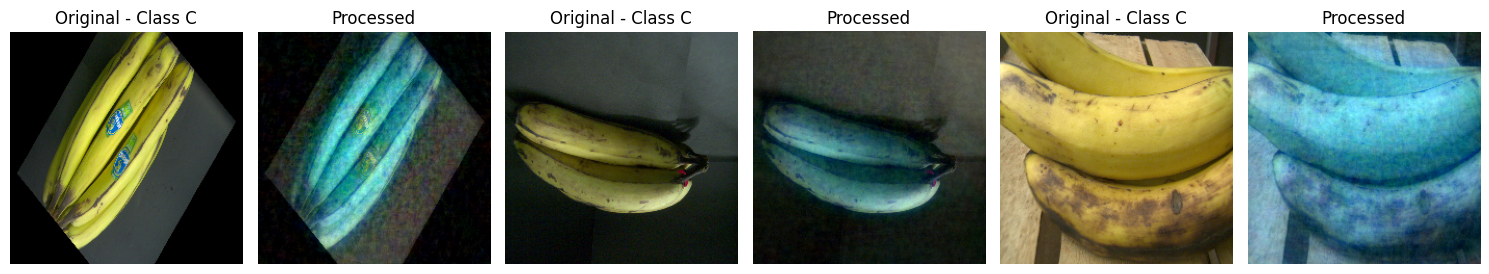

--- Class: Class D ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


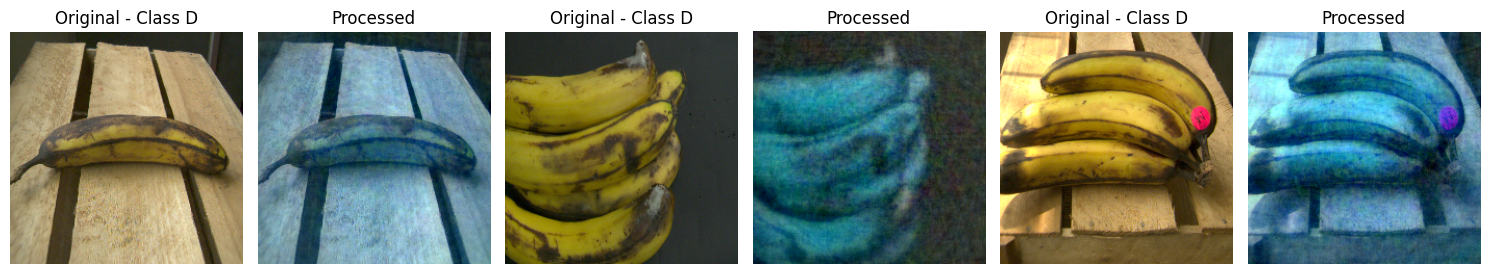

In [17]:
for class_name, images in all_class_images.items():
    num_images = len(images)
    fig, axs = plt.subplots(1, num_images * 2, figsize=(15, 6))
    print(f"--- Class: {class_name} ---")

    for j, image in enumerate(images):
        axs[j * 2].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[j * 2].set_title(f"Original - {class_name}")
        axs[j * 2].axis("off")

        processed_image = apply_pca_to_image(image, pca)

        # Display the processed image using matplotlib
        axs[j * 2 + 1].imshow(processed_image)
        axs[j * 2 + 1].set_title(f"Processed")
        axs[j * 2 + 1].axis("off")

    plt.tight_layout()
    plt.show()

## PCA after Color Thresholding

In [7]:
def remove_background_color_thresholding(image, class_color_ranges):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    final_mask = np.zeros_like(image)

    for color_name, (lower_bound, upper_bound) in class_color_ranges.items():
        mask = cv2.inRange(hsv, lower_bound, upper_bound)
        final_mask = cv2.bitwise_or(final_mask, cv2.merge([mask] * 3))

    result = cv2.bitwise_and(image, final_mask)
    return result

In [9]:
color_ranges = {
    "Class A": {  # 1 - 6 days
        "Yellow": (
            np.array([0, 50, 50]),
            np.array([100, 255, 255]),
        ),
        "Green": (
            np.array([0, 40, 40]),
            np.array([100, 255, 255]),
        ),
    },
    "Class B": {  # 7 - 14 days
        "Yellow": (
            np.array([0, 50, 50]),
            np.array([100, 255, 255]),
        ),
        "Green": (np.array([0, 40, 40]), np.array([100, 255, 255])),
    },
    "Class C": {  # 15 - 22 days
        "Yellow": (np.array([0, 50, 50]), np.array([60, 255, 255])),
        "Green": (np.array([0, 40, 40]), np.array([100, 255, 255])),
        "Brown": (np.array([20, 60, 60]), np.array([50, 255, 200])),
    },
    "Class D": {  # 23 - 28 days
        "Yellow": (
            np.array([0, 50, 50]),
            np.array([100, 255, 255]),
        ),
        "Green": (np.array([30, 40, 40]), np.array([120, 255, 255])),
        "Brown": (
            np.array([20, 30, 30]),
            np.array([90, 255, 255]),
        ),
    },
}

In [10]:
def load_images_with_processing(folder, class_color_ranges):
    images = []
    labels = []
    for class_folder in CLASSES:
        start_time = time.time()
        class_path = os.path.join(folder, class_folder)
        image_files = glob.glob(os.path.join(class_path, "*.png"))
        for img_file in image_files:
            processed_image = load_image(img_file)
            processed_image = remove_background_color_thresholding(
                processed_image, class_color_ranges[class_folder]
            )
            flattened_image = processed_image.flatten()
            images.append(flattened_image)
            labels.append(class_folder)
        end_time = time.time()
        duration = end_time - start_time
        print(f"Processing {class_folder} took {duration} seconds")
    return np.array(images), np.array(labels)

In [13]:
train_images, train_labels = load_images_with_processing(TRAIN_DIR, color_ranges)

Processing Class A took 2.854724168777466 seconds
Processing Class B took 1.6262969970703125 seconds
Processing Class C took 1.137359857559204 seconds
Processing Class D took 1.3303182125091553 seconds


In [14]:
pca_color_thresholding = PCA(n_components=2500)

In [15]:
pca_color_thresholding.fit(X=train_images, y=train_labels)

PCA(n_components=2500)

In [19]:
num_images_per_class = 3
all_class_images = {}
for class_name in CLASSES:
    images = extract_random_images(TRAIN_DIR, class_name, num_images_per_class)
    all_class_images[class_name] = images

--- Class: Class A ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


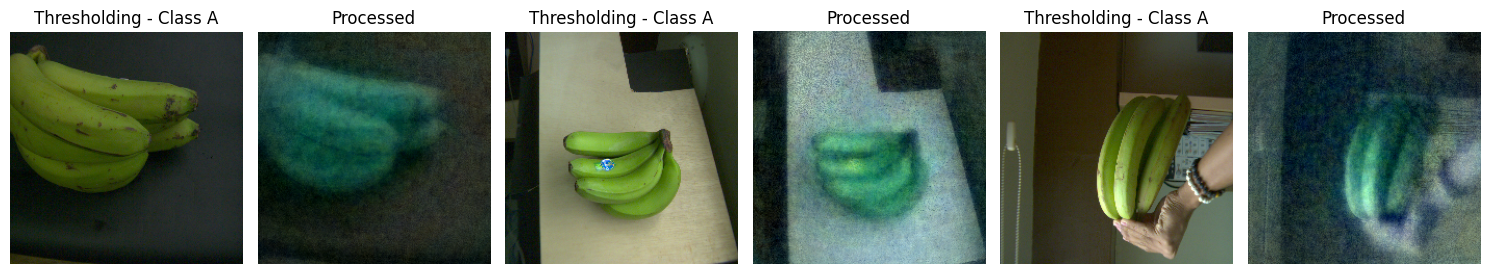

--- Class: Class B ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


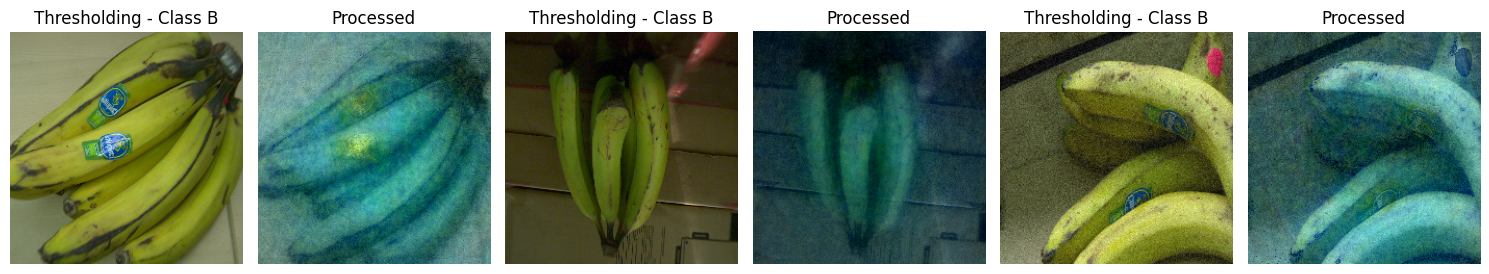

--- Class: Class C ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


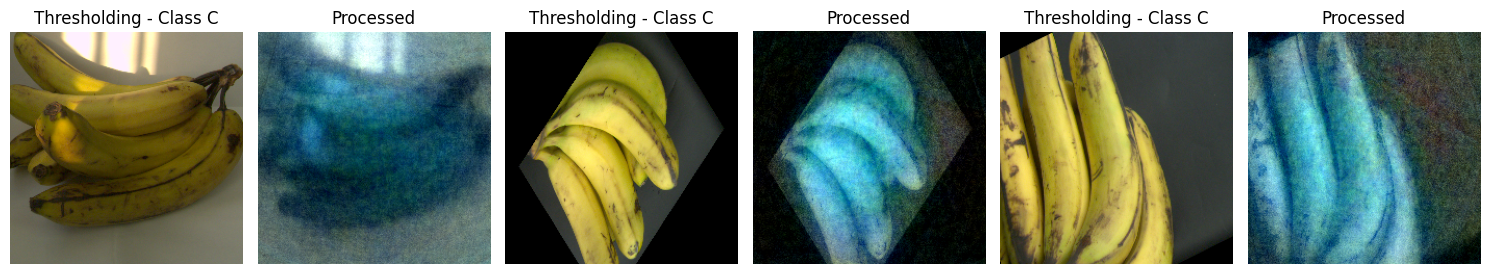

--- Class: Class D ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


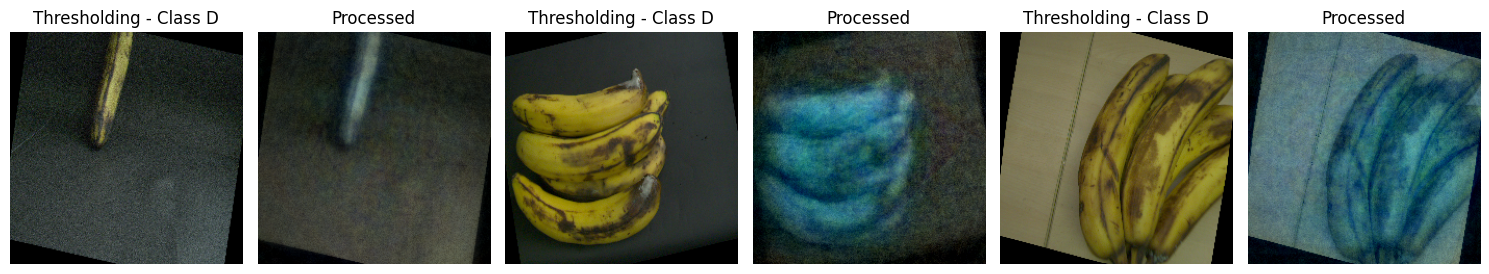

In [20]:
for class_name, images in all_class_images.items():
    num_images = len(images)
    fig, axs = plt.subplots(1, num_images * 2, figsize=(15, 6))
    print(f"--- Class: {class_name} ---")

    for j, image in enumerate(images):
        axs[j * 2].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[j * 2].set_title(f"Thresholding - {class_name}")
        axs[j * 2].axis("off")

        processed_image = apply_pca_to_image(image, pca_color_thresholding)

        # Display the processed image using matplotlib
        axs[j * 2 + 1].imshow(processed_image)
        axs[j * 2 + 1].set_title(f"Processed")
        axs[j * 2 + 1].axis("off")

    plt.tight_layout()
    plt.show()